# READ ME

This notebook is implemeted in a repository in github with input and output folders.
<br> It has 3 parts:
<br> Part 1: Pre-defined funtions for each technique.
<br> Part 2: Execution of model pipelines, here users can modify which combination of techniques they want to run. The scores will be printed as a csv in output folders.
<br> Part 3: Visualization (to be used in presentation)

### RECOMMENDATION:
It will take hours to run Part 2 (grid search), therefore, please run Part 1 and 3 only. I already exported the result in csv so that you can easily see them without having to run them again.

# PART 1: FUNCTIONS

## Import library

In [6]:
#importing libraries
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from BorutaShap import BorutaShap
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from collections import Counter
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, log_loss, cohen_kappa_score, make_scorer

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical 

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import plotly.express as px
import visualkeras

## Read df

In [7]:
#this function is to read, transform and join 2 data frame

def read_features():
    path = 'input/secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df


def read_target():
    path = 'input/secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df


## Remove duplicated columns

In [8]:
#find the duplicated features (columns)
def remove_duplicated_columns(df):
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)

    return df.drop(columns=to_remove, axis = 1)

# X = remove_duplicated_columns(X)
# X.shape


## Remove columns with Constant volatility (std=0)

In [9]:
def remove_constant_volatility(df):
    df_EDA= df.describe().T
    df_EDA= df_EDA[df_EDA["std"] == 0]
    df = df.drop(axis=1, columns=df_EDA.index)
    return df

# X = remove_constant_volatility(X)
# X.shape

## Remove columns with high %Missing values

In [10]:
def remove_cols_with_high_pct_null(df, null_threshold):
    list_column_with_pct_null = pd.concat([df.isnull().sum(), df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    list_column_with_pct_null= list_column_with_pct_null[list_column_with_pct_null["Percentage (%)"] >= null_threshold]
    df = df.drop(axis=1, columns=list_column_with_pct_null.index)
    return df

# X = remove_cols_with_high_pct_null(X, 0.8)
# X.shape

## Split data

In [11]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1,stratify=y)

## Outlier treatment

In [12]:
#how = ['NaN', '3s' ,'nothing']
def replace_outlier(df, how):
    for col in df:
        ll_col = df[col].mean() - 3 * df[col].std()
        ul_col = df[col].mean() + 3 * df[col].std()
        if how == 'NaN':
            df[col] = np.where(df[col]>ul_col,np.NaN,np.where(df[col]<ll_col,np.NaN,df[col]))
        elif how == '3s':
            df[col] = np.where(df[col]>ul_col,ul_col,np.where(df[col]<ll_col,ll_col,df[col]))
    return df

## Missing value Imputation

In [13]:
#which_weights = ['distance','uniform']

def impute_null_with_knn(X_train, X_test, which_weights):
    #First scale the data 
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns= X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns= X_test.columns)

    knn = KNNImputer(n_neighbors=5, weights=which_weights) #check this neighbors = 5

    X_train = pd.DataFrame(knn.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(knn.transform(X_test), columns=X_test.columns)
    
    X_train = pd.DataFrame(scaler.inverse_transform(X_train), columns= X_train.columns)
    X_test = pd.DataFrame(scaler.inverse_transform(X_test), columns= X_test.columns)
    return X_train, X_test

#X_train = impute_null_with_knn(X_train)

In [14]:
def impute_null_with_mice(X_train, X_test): 
    imp = IterativeImputer(max_iter=5, verbose=0, imputation_order='roman', random_state=0)
    X_train = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)
    return X_train, X_test

## Feature Selection

In [15]:
#This is BorutaShap with TENTATIVE features

#list_method=['shap','gini']

def BorutaShap_FS (X, y, method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = False,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

In [16]:
#RFE

#classifier = ['RF', 'SVM']

def RFE_FS (X, y,classify) :
    scaler = MinMaxScaler()
    X_scaled= pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    feature_names = np.array(X_scaled.columns)
    if classify == 'RF':
    # define random forest classifier
        model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
       
    if classify== 'SVM':
        model = SVC(kernel='linear',C=5)
        #rfe = RFECV(estimator = model,scoring='accuracy')
    # find all relevant features
    model.fit(X_scaled, y)
    rfe = RFE(estimator = model,n_features_to_select = 30)
    rfe.fit(X_scaled,y)

     # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             rfe.ranking_, 
                             rfe.support_))

    final_features_rfe = list()
    indexes = np.where(rfe.ranking_ <= 2)
    for x in np.nditer(indexes):
        final_features_rfe.append(feature_names[x])
    
    
    # unscale the data before return
    X_unscaled=pd.DataFrame(scaler.inverse_transform(X_scaled), columns=X_scaled.columns)
    ff_rfe=pd.DataFrame(X_unscaled.filter(final_features_rfe))
    

 # call transform() on X to filter it down to selected features
    return  ff_rfe

In [17]:
#Boruta function with random forest

def BorutaPy_FS (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)
    # define Boruta feature selection method
    
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=100, max_iter=140)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 2) #change to 2
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features))

## Balancing

In [18]:
def sampling(X_train, y_train, sampler):
    
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
        
    #Random under Sampling
    if sampler == "randomunder":
        sampler = RandomUnderSampler(random_state=100)

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    #counter = Counter(y_resampled)
    #print(counter)
    
    return X_resampled, y_resampled

# X_train, y_train = sampling(X_train, y_train,'SMOTE')
# X_train.shape

## Model: Deep Neural Network

#Note:
<br>How to Use Keras Models in scikit-learn:
<br>-Keras models can be used in scikit-learn by wrapping them with the KerasClassifier or KerasRegressor class.
<br>-To use these wrappers you must define a function that creates and returns your Keras sequential model, then pass this function to the build_fn argument when constructing the KerasClassifier class.
<br>https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


In [19]:
#the accuracy that is produced by keras is similar to the one being manually calculated by argmax, same with scikit learn evaluate
#grid seach does not build to apply on test set, after finding the best hyperparamter, we need to fit the model on train set again and use it for test set

#### Building the model

In [20]:
def create_model_NN(batch_size=100, epochs=50, activation='linear', dropout_rate=0.0, neurons=10):

    input_dim = X_train.shape[1]

    model = Sequential()
    model.add(Dense(round((input_dim+2)/2)*neurons, activation=activation, input_dim=input_dim, kernel_initializer='random_normal', bias_initializer='zeros'))
    model.add(Dropout(dropout_rate))
    #model.add(Dense(round((neurons*5+2)/2), activation=activation))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return model

#### Create combinations of Hyperparameters for "Grid-search"

In [21]:
#create a listf of dictionary of params
search_params=[]

batch_size = [100, 150, 200,500]
epochs = [10, 20, 50, 100]
activation = ['linear','softmax','relu'] 
dropout_rate = [0,0.1,0.3,0.5]
neurons = [0.5,1,1.5,2]

# batch_size = [100]
# epochs = [10]
# activation = ['linear'] 
# dropout_rate = [0,0.1]
# neurons = [1,2]

#create a dictionary of hyperparameter combinations
for b in batch_size:
    for e in epochs:
        for a in activation:
            for d in dropout_rate:
                for n in neurons:
                    search_params.append({'batch_size':b,'epochs':e,'activation':a,'dropout_rate':d,'neurons':n})


# PART 2: EXECUTION

### 2.1 PRE-MODEL TREATEMENT

In [222]:
#step 1:
# reading data
X = read_features()
y = read_target().iloc[:,0]
#split data into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify=y)

# step 2:
X_train = remove_duplicated_columns(X_train)

#step 3:
X_train = remove_constant_volatility(X_train)

#step 4:
X_train = remove_cols_with_high_pct_null(X_train, 0.5) #this can be in the loop too, may be later
#step 5: remove the same columns from step 2-4 TRAIN_TEST split
X_test = X_test.loc[:,X_train.columns]

#step 6: oulier treatement (on both TRAIN & TEST split)
X_train = replace_outlier(X_train, '3s')
X_test = replace_outlier(X_test, '3s')

#step 7: missing value imputation (on both TRAIN & TEST split)
X_train, X_test = impute_null_with_knn(X_train, X_test, 'distance')

#step 8: feature selection (on both TRAIN & TEST split)
X_train = BorutaShap_FS(X_train, y_train, 'shap')

#make test set have the SAME features as train set
X_test = X_test.loc[:,X_train.columns]

#step 9: balancing only on TRAIN split
X_train, y_train = sampling(X_train, y_train, 'SMOTEENN')

# prepare the y set: to_categorical cannot work with negative numbers
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)
#one hot encode outputs
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


In [120]:
print(X_train.shape, y_train.shape)

(1845, 16) (1845,)


### 2.2 FITTING MODELS

Note:
<br>I built my one grid search because the existing library from Keras and sciki-learn cannot record all the metrics that I need

In [121]:
#initiate the metrics as empty list, these metrics will be exported into csv later

test_cf_matrix, test_accuracy, test_f1, test_precision, test_recall, test_auc, test_type_1_error_FP, test_type_2_error_FN, test_log_loss, test_cohen_kappa_score = [],[],[],[],[],[],[],[],[],[]
hyperparam, l_fold, l_batch_size, l_epochs, l_activation, l_dropout_rate, l_neurons = [],[],[],[],[],[],[]

#initiat a dictionary to store the scores
dict_scores = {}


skf = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True) 

#create temp variables to store the original values before applying CV
X_train_temp = X_train
y_train_c_temp = y_train_c
X_test_temp = X_test
y_test_c_temp = y_test_c

fold = 0
for train_index, test_index in skf.split(X_train, y_train): #here I use y_train instead of y_train_c because skf.split should read binary value
    fold = fold+1
    X_train, X_test = X_train_temp.iloc[train_index,], X_train_temp.iloc[test_index,] #.iloc because this is pandas df not numpy array
    #here you can see that another train & test split are born from X_train_temp, not X_test_temp
    y_train_c, y_test_c = y_train_c_temp[train_index,], y_train_c_temp[test_index,] #y on the other hand is numpy array

    for p in search_params:
        real_model = create_model_NN(**p) #p are set of parameters that have been created by the for-loops above
        real_model.fit(X_train,y_train_c, epochs= p['epochs'], batch_size = p['batch_size'], verbose=0)
        
        #record the papameters to export into csv later
        l_fold.append(fold)
        hyperparam.append(p)
        l_batch_size.append(p['batch_size'])
        l_epochs.append(p['epochs'])
        l_activation.append(p['activation'])
        l_dropout_rate.append(p['dropout_rate'])
        l_neurons.append(p['neurons'])   



        ###### TEST SCORES OF CROSS VALIDATION_SET SET
        #create predicted y
        y_pred = real_model.predict(X_test)
        #Converting y-predicted to labels
        pred = list()
        for i in range(len(y_pred)):
            pred.append(np.argmax(y_pred[i]))

        #Converting y-test to labels
        test = list()
        for i in range(len(y_test_c)):
            test.append(np.argmax(y_test_c[i]))
            
        test_cf_matrix.append(confusion_matrix(test, pred))
        test_accuracy.append(accuracy_score(test, pred)) #these are library from scikit learn, this yield the same result as the one of keras mode.evaluate()
        test_f1.append(f1_score(test, pred)) 
        test_precision.append(precision_score(test, pred))
        test_recall.append(recall_score(test, pred))
        test_auc.append(roc_auc_score(test, pred))
        test_type_1_error_FP.append(confusion_matrix(test, pred)[0][1])
        test_type_2_error_FN.append(confusion_matrix(test, pred)[1][0])
        test_log_loss.append(log_loss(test, pred))
        test_cohen_kappa_score.append(cohen_kappa_score(test, pred))


    #create a dict of list
    dict_scores['fold'] = l_fold
    dict_scores['hyperparam'] = hyperparam

    dict_scores['batch_size'] = l_batch_size
    dict_scores['epochs'] = l_epochs
    dict_scores['activation'] = l_activation
    dict_scores['dropout_rate'] = l_dropout_rate
    dict_scores['neurons'] = l_neurons

    dict_scores['test_cf_matrix']=test_cf_matrix
    dict_scores['test_accuracy']=test_accuracy
    dict_scores['test_f1']=test_f1
    dict_scores['test_precision']=test_precision
    dict_scores['test_recall']=test_recall
    dict_scores['test_auc']=test_auc
    dict_scores['test_type_1_error_FP']=test_type_1_error_FP
    dict_scores['test_type_2_error_FN']=test_type_2_error_FN
    dict_scores['test_log_loss']=test_log_loss
    dict_scores['test_cohen_kappa_score']=test_cohen_kappa_score


df_scores = pd.DataFrame.from_dict(dict_scores)
df_scores.to_csv('output/scores_with_FS_final.csv')
df_scores['hyperparam_str'] = df_scores['hyperparam'].astype('string')

12/12 [==============================] - 0s 782us/step


In [272]:
#read the testing scores from csv file, in case we don't want to run all the codes above
df_scores = pd.read_csv('output/scores_with_FS_final.csv')
df_scores.head(1)

,Unnamed: 0.1,Unnamed: 0,fold,hyperparam,batch_size,epochs,activation,dropout_rate,neurons,test_cf_matrix,test_accuracy,test_f1,test_precision,test_recall,test_auc,test_type_1_error_FP,test_type_2_error_FN,test_log_loss,test_cohen_kappa_score,hyperparam_str
0,0,0,1,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.0,0.5,[[ 72 80]\n [ 51 166]],0.644986,0.717063,0.674797,0.764977,0.619331,80,51,12.261907,0.245681,"{'batch_size': 100, 'epochs': 10, 'activation'..."


In [273]:
#grouping the folds' scores
df_scores_grouped = df_scores.groupby(by=['hyperparam_str']).agg({  'test_accuracy':['mean'],
                                                                    'test_recall':['mean'],    
                                                                    'test_precision':['mean'],  
                                                                    'test_f1':['mean'],
                                                                    'test_type_1_error_FP':['mean'],
                                                                    'test_type_2_error_FN':['mean'],
                                                                    'test_auc':['mean']  
                                                                })
                                            
                           
df_scores_grouped.reset_index(inplace=True)
df_scores_grouped.columns = ['hyperparam','test_accuracy_mean','test_recall_mean', 'test_precision_mean', 'test_f1_mean','test_type_1_error_FP_mean', 'test_type_2_error_FN_mean','test_auc_mean']
cost_Type1_FP = 1
cost_Type2_FN = 5 #here we assumed this ratio of cost, we run a sensitivity analysis later
df_scores_grouped['test_cost_mean'] = df_scores_grouped['test_type_1_error_FP_mean']*cost_Type1_FP + df_scores_grouped['test_type_2_error_FN_mean']*cost_Type2_FN

print(df_scores_grouped.shape)
#merge the df_scores_group with df_scores to get the hyperparamater columns
df_scores_grouped = pd.merge(df_scores_grouped, df_scores[['hyperparam_str','batch_size','epochs','activation','dropout_rate','neurons']], left_on='hyperparam', right_on='hyperparam_str',how='left', suffixes=('','_drop')).drop_duplicates(subset=['hyperparam_str'],keep='first')

#export to csv
df_scores_grouped.to_csv('output/df_scores_grouped_final.csv')
df_scores_grouped.head()

(768, 9)


,hyperparam,test_accuracy_mean,test_recall_mean,test_precision_mean,test_f1_mean,test_type_1_error_FP_mean,test_type_2_error_FN_mean,test_auc_mean,test_cost_mean,hyperparam_str,batch_size,epochs,activation,dropout_rate,neurons
0,"{'batch_size': 100, 'epochs': 10, 'activation'...",0.572358,0.716860,0.623875,0.658699,96.2,61.6,0.541273,404.2,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.0,0.5
5,"{'batch_size': 100, 'epochs': 10, 'activation'...",0.593496,0.637547,0.664303,0.649677,71.2,78.8,0.584088,465.2,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.0,1.5
10,"{'batch_size': 100, 'epochs': 10, 'activation'...",0.625474,0.668938,0.691936,0.677355,66.2,72.0,0.616188,426.2,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.0,1.0
15,"{'batch_size': 100, 'epochs': 10, 'activation'...",0.588618,0.647499,0.651531,0.648142,75.2,76.6,0.575732,458.2,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.0,2.0
20,"{'batch_size': 100, 'epochs': 10, 'activation'...",0.558266,0.679952,0.616161,0.644027,93.4,69.6,0.531842,441.4,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.1,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3815,"{'batch_size': 500, 'epochs': 50, 'activation'...",0.576152,0.776147,0.492518,0.600263,107.8,48.6,0.532444,350.8,"{'batch_size': 500, 'epochs': 50, 'activation'...",500,50,softmax,0.3,2.0
3820,"{'batch_size': 500, 'epochs': 50, 'activation'...",0.518699,0.600000,0.353930,0.445227,90.8,86.8,0.500000,524.8,"{'batch_size': 500, 'epochs': 50, 'activation'...",500,50,softmax,0.5,0.5
3825,"{'batch_size': 500, 'epochs': 50, 'activation'...",0.626558,0.905069,0.644566,0.737490,117.2,20.6,0.565692,220.2,"{'batch_size': 500, 'epochs': 50, 'activation'...",500,50,softmax,0.5,1.5
3830,"{'batch_size': 500, 'epochs': 50, 'activation'...",0.589160,1.000000,0.589160,0.741473,151.6,0.0,0.500000,151.6,"{'batch_size': 500, 'epochs': 50, 'activation'...",500,50,softmax,0.5,1.0


In [264]:
###################################

### 2.4 APPLY BEST HYPERPARAMETERS ON TEST SET

In [265]:
#the best hyperparameters
best_p_collection =[]
for r in range(5):
    best_p_collection.append(eval(df_scores_grouped.sort_values(by=['test_cost_mean']).iloc[r,0]))

best_p_collection

[{'batch_size': 150,
  'epochs': 100,
  'activation': 'softmax',
  'dropout_rate': 0.5,
  'neurons': 1},
 {'batch_size': 100,
  'epochs': 20,
  'activation': 'softmax',
  'dropout_rate': 0.5,
  'neurons': 0.5},
 {'batch_size': 150,
  'epochs': 50,
  'activation': 'softmax',
  'dropout_rate': 0.5,
  'neurons': 0.5},
 {'batch_size': 150,
  'epochs': 50,
  'activation': 'softmax',
  'dropout_rate': 0.3,
  'neurons': 0.5},
 {'batch_size': 100,
  'epochs': 100,
  'activation': 'softmax',
  'dropout_rate': 0.1,
  'neurons': 0.5}]

In [266]:
#At this stage, we have the best hyperparamaters from the step above
#Let's apply them on TEST SET

#return the original values to these variables (as we overwrote them in CV step)
X_train = X_train_temp
X_test = X_test_temp
y_train_c = y_train_c_temp
y_test_c = y_test_c_temp

TEST_cf_matrix, TEST_accuracy, TEST_f1, TEST_precision, TEST_recall, TEST_auc, TEST_type_1_error_FP, TEST_type_2_error_FN, TEST_log_loss, TEST_cohen_kappa_score = [],[],[],[],[],[],[],[],[],[]


for p in best_p_collection:
    real_model = create_model_NN(**p) #p are set of parameters that have been created by the for-loops above
    #fit the model with best hyperparameters on TRAIN SET
    real_model.fit(X_train,y_train_c, epochs= p['epochs'], batch_size = p['batch_size'], verbose=0)

        
    #and then we produce final scores by fit the model with TEST SET
    #create predicted y
    y_pred = real_model.predict(X_test)
    #Converting y-predicted to labels
    pred = list()
    for i in range(len(y_pred)):
        pred.append(np.argmax(y_pred[i]))

    #Converting y-test to labels
    test = list()
    for i in range(len(y_test_c)):
        test.append(np.argmax(y_test_c[i]))

    
    TEST_cf_matrix.append(confusion_matrix(test, pred))
    TEST_accuracy.append(accuracy_score(test, pred)) #these are library from scikit learn, this yield the same result as the one of keras mode.evaluate()
    TEST_f1.append(f1_score(test, pred)) 
    TEST_precision.append(precision_score(test, pred))
    TEST_recall.append(recall_score(test, pred))
    TEST_auc.append(roc_auc_score(test, pred))
    TEST_type_1_error_FP.append(confusion_matrix(test, pred)[0][1])
    TEST_type_2_error_FN.append(confusion_matrix(test, pred)[1][0])
    TEST_log_loss.append(log_loss(test, pred))
    TEST_cohen_kappa_score.append(cohen_kappa_score(test, pred))

    dict_scores_TEST={}
    dict_scores_TEST['TEST_cf_matrix']=TEST_cf_matrix
    dict_scores_TEST['TEST_accuracy']=TEST_accuracy
    dict_scores_TEST['TEST_f1']=TEST_f1
    dict_scores_TEST['TEST_precision']=TEST_precision
    dict_scores_TEST['TEST_recall']=TEST_recall
    dict_scores_TEST['TEST_auc']=TEST_auc
    dict_scores_TEST['TEST_type_1_error_FP']=TEST_type_1_error_FP
    dict_scores_TEST['TEST_type_2_error_FN']=TEST_type_2_error_FN
    dict_scores_TEST['TEST_log_loss']=TEST_log_loss
    dict_scores_TEST['TEST_cohen_kappa_score']=TEST_cohen_kappa_score

df_scores_TEST_SET = pd.DataFrame.from_dict(dict_scores_TEST)

#finding the best hypeparameters among the top 5
df_scores_TEST_SET.sort_values(by=['TEST_type_2_error_FN','TEST_type_1_error_FP']) #should be inplace=True

10/10 [==============================] - 0s 1ms/step


,TEST_cf_matrix,TEST_accuracy,TEST_f1,TEST_precision,TEST_recall,TEST_auc,TEST_type_1_error_FP,TEST_type_2_error_FN,TEST_log_loss,TEST_cohen_kappa_score
1,"[[107, 186], [6, 15]]",0.388535,0.135135,0.074627,0.714286,0.539737,186,6,21.119725,0.015963
3,"[[174, 119], [7, 14]]",0.598726,0.181818,0.105263,0.666667,0.630262,119,7,13.859812,0.074959
0,"[[215, 78], [8, 13]]",0.726115,0.232143,0.142857,0.619048,0.676418,78,8,9.459863,0.138518
2,"[[181, 112], [8, 13]]",0.617834,0.178082,0.104000,0.619048,0.618398,112,8,13.199818,0.071784
4,"[[238, 55], [9, 12]]",0.796178,0.272727,0.179104,0.571429,0.691858,55,9,7.039891,0.190265


<AxesSubplot:>

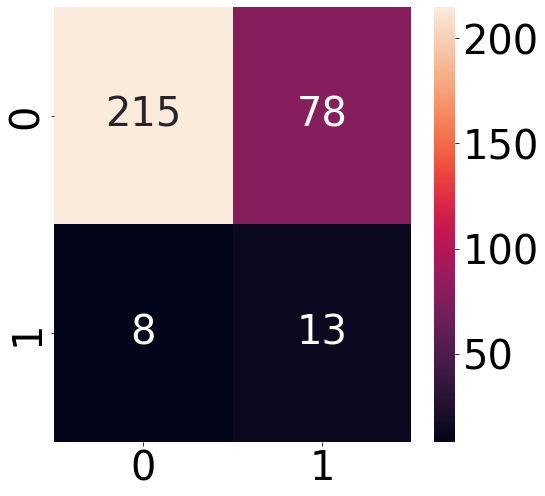

In [331]:
plt.rcParams.update({'font.size': 40})
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(df_scores_TEST_SET.iloc[0,0],annot=True, fmt='g') #the df_scores_TEST_SET should be sorted first

In [238]:
X_train.shape

(1845, 16)

# PART 3: Visualization

##### Import libraries and read data

In [2]:
import re
import pandas as pd
import seaborn as sns
import plotly.express as px
import visualkeras
pd.set_option('display.max_columns', None)

In [23]:
df_scores_grouped = pd.read_csv('output/df_scores_grouped_final.csv')
df_scores_grouped.head(1)

,Unnamed: 0,hyperparam,test_accuracy_mean,test_recall_mean,test_precision_mean,test_f1_mean,test_type_1_error_FP_mean,test_type_2_error_FN_mean,test_auc_mean,test_cost_mean,hyperparam_str,batch_size,epochs,activation,dropout_rate,neurons
0,0,"{'batch_size': 100, 'epochs': 10, 'activation'...",0.572358,0.71686,0.623875,0.658699,96.2,61.6,0.541273,404.2,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.0,0.5


##### Pair plots of key scores

<AxesSubplot:xlabel='test_auc_mean', ylabel='test_accuracy_mean'>

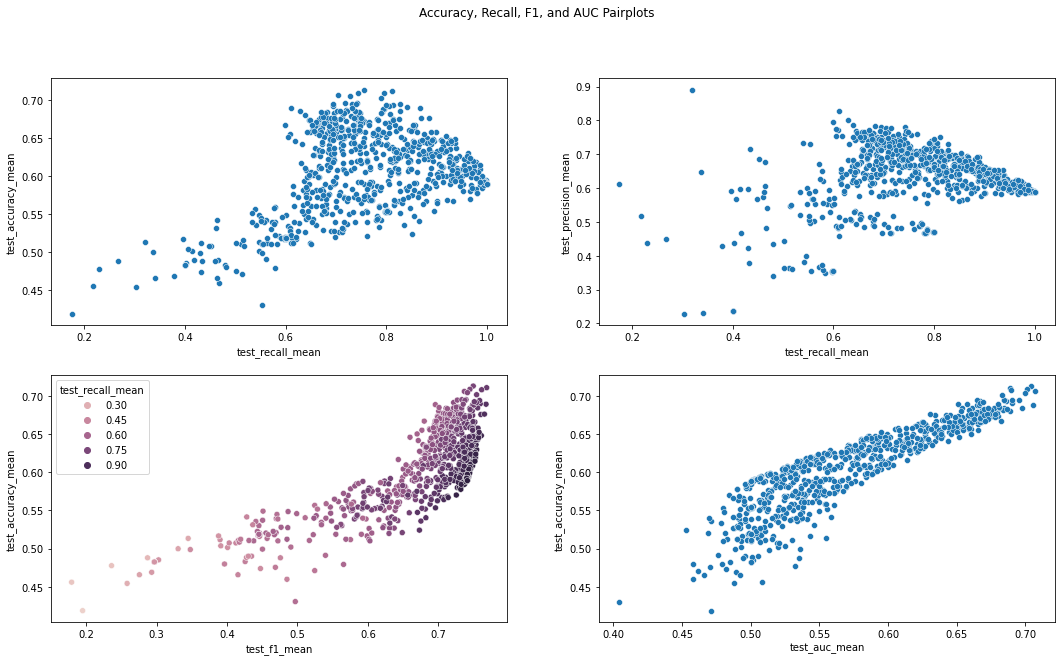

In [24]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Accuracy, Recall, F1, and AUC Pairplots')

sns.scatterplot(ax=axes[0, 0], data=df_scores_grouped, x='test_recall_mean', y='test_accuracy_mean')
sns.scatterplot(ax=axes[0, 1], data=df_scores_grouped, x='test_recall_mean', y='test_precision_mean')
sns.scatterplot(ax=axes[1, 0], data=df_scores_grouped, x='test_f1_mean', y='test_accuracy_mean', hue='test_recall_mean')
sns.scatterplot(ax=axes[1, 1], data=df_scores_grouped, x='test_auc_mean', y='test_accuracy_mean')

##### Batch size vs Epoch

epochs           10        20        50        100
batch_size                                        
100         0.752979  0.803939  0.794694  0.795291
150         0.714323  0.771232  0.788682  0.811480
200         0.703863  0.799022  0.792214  0.809936
500         0.627058  0.689225  0.755946  0.779425


<AxesSubplot:xlabel='epochs', ylabel='batch_size'>

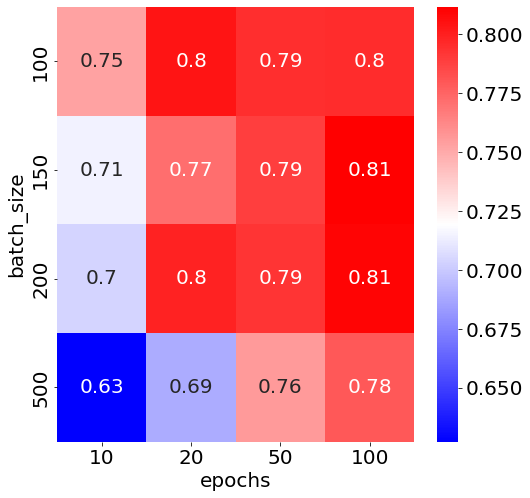

In [321]:
#RECALL
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
df_reshaped = pd.pivot_table(df_scores_grouped, values='test_recall_mean', index='batch_size', columns='epochs', aggfunc=np.mean)
print(df_reshaped)
sns.heatmap(df_reshaped, annot=True, cmap='bwr')

epochs           10        20        50        100
batch_size                                        
100         0.613476  0.660089  0.693050  0.705806
150         0.579863  0.633720  0.683973  0.688882
200         0.553197  0.635562  0.673420  0.687057
500         0.526372  0.552210  0.610074  0.660642


<AxesSubplot:xlabel='epochs', ylabel='batch_size'>

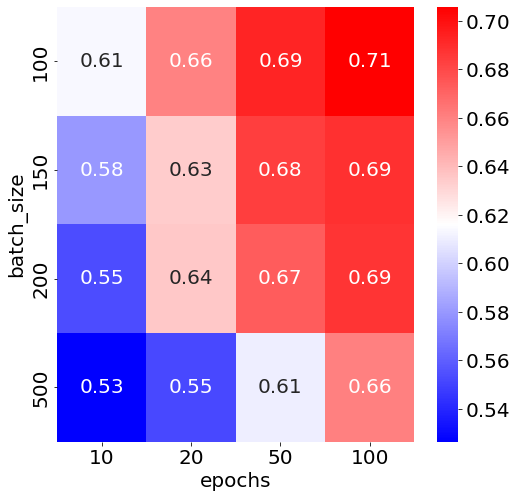

In [322]:
#PRECISION
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
df_reshaped = pd.pivot_table(df_scores_grouped, values='test_precision_mean', index='batch_size', columns='epochs', aggfunc=np.mean)
print(df_reshaped)
sns.heatmap(df_reshaped, annot=True, cmap='bwr')

##### No. of Neurons and Activation function

activation    linear      relu   softmax
neurons                                 
0.5         0.658849  0.721594  0.806237
1.0         0.716282  0.726633  0.849423
1.5         0.735552  0.748111  0.839345
2.0         0.746752  0.761054  0.832148


<AxesSubplot:xlabel='activation', ylabel='neurons'>

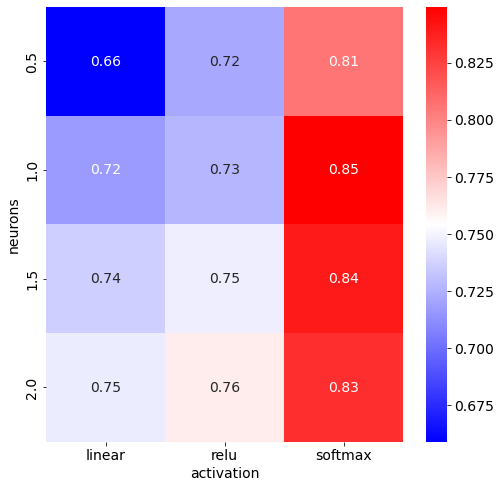

In [307]:
#RECALL
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
df_reshaped = pd.pivot_table(df_scores_grouped, values='test_recall_mean', index='neurons', columns='activation', aggfunc=np.mean)
print(df_reshaped)
sns.heatmap(df_reshaped, annot=True, cmap='bwr')

activation    linear      relu   softmax
neurons                                 
0.5         0.619944  0.595086  0.548030
1.0         0.667332  0.649422  0.596981
1.5         0.670563  0.648897  0.618095
2.0         0.690102  0.674514  0.639077


<AxesSubplot:xlabel='activation', ylabel='neurons'>

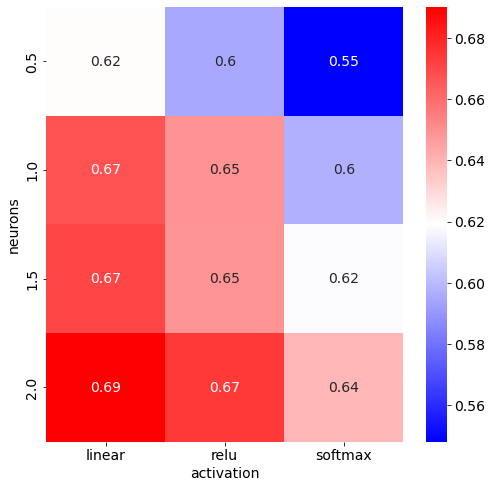

In [308]:
#PRECISION
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
df_reshaped = pd.pivot_table(df_scores_grouped, values='test_precision_mean', index='neurons', columns='activation', aggfunc=np.mean)
print(df_reshaped)
sns.heatmap(df_reshaped, annot=True, cmap='bwr')

         test_recall_mean
neurons                  
0.5              0.728894
1.0              0.764113
1.5              0.774336
2.0              0.779985


<AxesSubplot:ylabel='neurons'>

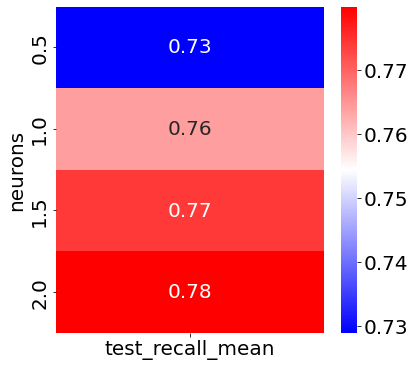

In [318]:
#RECALL NEURON
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
df_reshaped = pd.pivot_table(df_scores_grouped, values='test_recall_mean', index='neurons', aggfunc=np.mean)
print(df_reshaped)
sns.heatmap(df_reshaped, annot=True, cmap='bwr')

         test_precision_mean
neurons                     
0.5                 0.587687
1.0                 0.637912
1.5                 0.645852
2.0                 0.667898


<AxesSubplot:ylabel='neurons'>

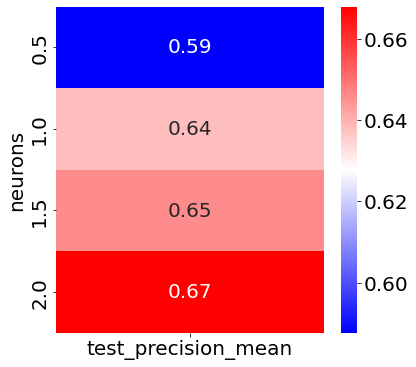

In [319]:
#RECALL PRECISION
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
df_reshaped = pd.pivot_table(df_scores_grouped, values='test_precision_mean', index='neurons', aggfunc=np.mean)
print(df_reshaped)
sns.heatmap(df_reshaped, annot=True, cmap='bwr')

##### Drop out rates

              test_recall_mean
dropout_rate                  
0.0                   0.723516
0.1                   0.740753
0.3                   0.775612
0.5                   0.807446


<AxesSubplot:ylabel='dropout_rate'>

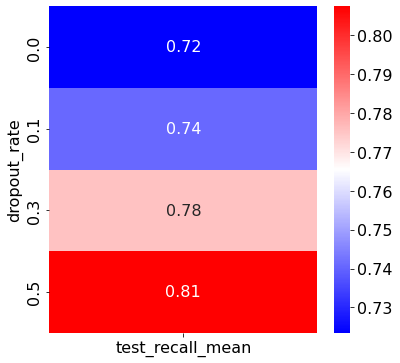

In [314]:
#PRECISION
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
df_reshaped = pd.pivot_table(df_scores_grouped, values='test_recall_mean', index='dropout_rate', aggfunc=np.mean)
print(df_reshaped)
sns.heatmap(df_reshaped, annot=True, cmap='bwr')

              test_precision_mean
dropout_rate                     
0.0                      0.650046
0.1                      0.641430
0.3                      0.620764
0.5                      0.627109


<AxesSubplot:ylabel='dropout_rate'>

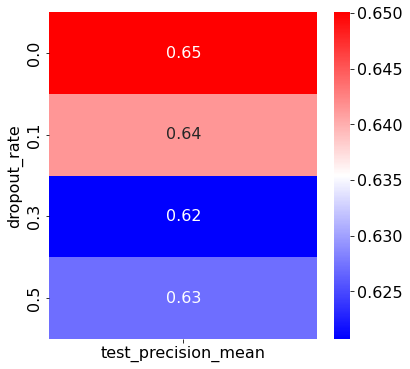

In [315]:
#PRECISION
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
df_reshaped = pd.pivot_table(df_scores_grouped, values='test_precision_mean', index='dropout_rate', aggfunc=np.mean)
print(df_reshaped)
sns.heatmap(df_reshaped, annot=True, cmap='bwr')

In [323]:
px.scatter_3d(df_scores_grouped, x='test_recall_mean', y='test_precision_mean', z='test_cost_mean', color='test_cost_mean', size='test_accuracy_mean', opacity=1, width=1000, height=800)


<AxesSubplot:xlabel='test_accuracy', ylabel='train_accuracy'>

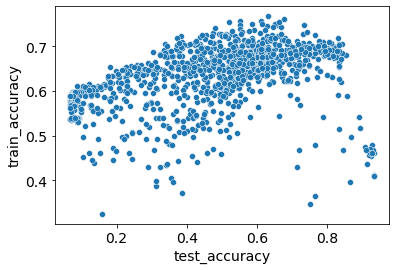

In [92]:
#plotting test and train accuracy to investigate overfitting
sns.scatterplot(data=df_scores, x='test_accuracy', y='train_accuracy')